In [ ]:
#Importing Necessary Libraries
import cv2
import os
import shutil
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('Drive')

Mounted at Drive


# Data Read

In [ ]:
zip_path = '/content/Drive/MyDrive/archive.zip'  # Ganti dengan path ke file zip Anda di Google Drive
shutil.copy(zip_path, '/content/')

'/content/archive.zip'

In [ ]:
import zipfile

with zipfile.ZipFile('/content/archive.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/CervicalCancer')  # Ganti dengan direktori tujuan ekstraksi

# Data Preprocessing

In [ ]:
# Function for Formatting Dataset
def FormatDataset(dataset_src, dataset_dest, classes):
    # Making a Copy of Dataset
    new_cropped_dest = [os.path.join(dataset_dest, cls, 'CROPPED') for cls in classes];
    new_complete_dest = [os.path.join(dataset_dest, cls, 'COMPLETE') for cls in classes];
    cropped_src = [ dataset_src + "/im_" + cls + "/im_" + cls + "/CROPPED" for cls in classes ];
    complete_src = [ dataset_src + "/im_" + cls + "/im_" + cls for cls in classes ];
    for (dest1, dest2) in zip(new_cropped_dest, new_complete_dest):
        os.makedirs(dest1);
        os.makedirs(dest2);
    # Formating Cropped Images
    for (src,new_dest) in zip(cropped_src, new_cropped_dest):
        for file in os.listdir(src):
            filename, file_ext = os.path.splitext(file);
            if file_ext == '.bmp':
                img_des = os.path.join(new_dest, filename + '.jpg');
                img = cv2.imread(os.path.join(src, file));
                img = cv2.resize(img, (64, 64));
                img = cv2.copyMakeBorder(img, 1, 1, 1, 1, cv2.BORDER_CONSTANT, value=0);
                img = cv2.blur(img, (2, 2));
                cv2.imwrite(img_des ,img);
    # Formatting Complete Images
    for (src,new_dest) in zip(complete_src, new_complete_dest):
        for file in os.listdir(src):
            filename, file_ext = os.path.splitext(file);
            if file_ext == '.bmp':
                img_des = os.path.join(new_dest, filename + '.jpg');
                img = cv2.imread(os.path.join(src, file));
                img = cv2.resize(img, (256, 256));
                img = cv2.copyMakeBorder(img, 2, 2, 2, 2, cv2.BORDER_CONSTANT, value=0);
                img = cv2.blur(img, (2, 2));
                cv2.imwrite(img_des ,img);


In [ ]:
root_dir = "/content/baru"
classes = ["Dyskeratotic","Koilocytotic","Metaplastic","Parabasal","Superficial-Intermediate"]

def GetDatasetSize(path, classes, main = "CROPPED"):
    num_of_image = {}
    for cls in classes:
        # Counting the Number of Files in the Folder
        num_of_image[cls] = len(os.listdir(os.path.join(path, cls, main)));
    return num_of_image;

print(GetDatasetSize(root_dir, classes, "COMPLETE"));

{'Dyskeratotic': 223, 'Koilocytotic': 238, 'Metaplastic': 117, 'Parabasal': 0, 'Superficial-Intermediate': 0}


# Data Split

In [ ]:
# Function for Creating Train / Validation / Test folders (One time use Only)

def TrainValTestSplit(root_dir, classes_dir, main = "CROPPED", val_ratio = 0.15, test_ratio = 0.15):
    for cls in classes_dir:
        # Creating Split Folders
        os.makedirs('train/' + cls)
        os.makedirs('val/' + cls)
        os.makedirs('test/' + cls)

        # Folder to copy images from
        src = os.path.join(root_dir, cls, main);

        # Spliting the Files in the Given ratio
        allFileNames = os.listdir(src)
        np.random.shuffle(allFileNames)
        train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames), [int(len(allFileNames)* (1 - (val_ratio + test_ratio))), int(len(allFileNames)* (1 - test_ratio))])

        train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
        val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]
        test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

        # Printing the Split Details
        print(cls,':')
        print('Total images: ', len(allFileNames))
        print('Training: ', len(train_FileNames))
        print('Validation: ', len(val_FileNames))
        print('Testing: ', len(test_FileNames))

        # Copy-pasting images
        for name in train_FileNames:
            shutil.copy(name, 'train/' + cls)

        for name in val_FileNames:
            shutil.copy(name, 'val/' + cls)

        for name in test_FileNames:
            shutil.copy(name, 'test/' + cls)
        print();


# Preforming Train / Validation / Test Split
root_dir = "/content/baru"               # Dataset Root Folder
classes_dir = ["Dyskeratotic", "Koilocytotic", "Metaplastic", "Parabasal", "Superficial-Intermediate"]   # Classes
TrainValTestSplit(root_dir, classes_dir);

Dyskeratotic :
Total images:  813
Training:  569
Validation:  122
Testing:  122

Koilocytotic :
Total images:  825
Training:  577
Validation:  124
Testing:  124

Metaplastic :
Total images:  793
Training:  555
Validation:  119
Testing:  119

Parabasal :
Total images:  787
Training:  550
Validation:  118
Testing:  119

Superficial-Intermediate :
Total images:  831
Training:  581
Validation:  125
Testing:  125



# Model

In [ ]:
# Importing Keras for Image Classification
import keras
from keras.layers import Dense,Conv2D, Flatten, MaxPool2D, Dropout
from keras.models import Sequential
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

In [ ]:
# Expand the size of dataset with new transformed images from the original dataset using ImageDataGenerator.
train_datagen = image.ImageDataGenerator(zoom_range = 0.2, shear_range = 0.2 , rescale = 1./255 , horizontal_flip=True)
val_datagen = image.ImageDataGenerator(rescale = 1./255)
test_datagen = image.ImageDataGenerator(rescale = 1./255)

In [ ]:
train_data = train_datagen.flow_from_directory(directory= "./train", target_size=(64, 64), batch_size=100, class_mode = 'categorical')

Found 2832 images belonging to 5 classes.


In [ ]:
train_data.class_indices

{'Dyskeratotic': 0,
 'Koilocytotic': 1,
 'Metaplastic': 2,
 'Parabasal': 3,
 'Superficial-Intermediate': 4}

In [ ]:
val_data = val_datagen.flow_from_directory(directory= "./val", target_size=(64, 64), batch_size=100, class_mode = 'categorical')

Found 608 images belonging to 5 classes.


In [ ]:
test_data = test_datagen.flow_from_directory(directory= "./test", target_size=(64, 64), batch_size=100, class_mode = 'categorical')

Found 609 images belonging to 5 classes.


In [ ]:
!pip install visualkeras
import visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 10.1 MB/s eta 0:00:00


## CNN model bawaan Kaggle

In [ ]:
# CNN dari Kaggle
model1 = Sequential()
# Convolutional Layer with input shape (64,64,3)
model1.add(Conv2D(filters=16, kernel_size= (3,3), activation= 'relu', input_shape=(64,64,3)) )

model1.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu' ))
model1.add(MaxPool2D(pool_size=(2,2)))


model1.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu' ))
model1.add(MaxPool2D(pool_size=(2,2)))


model1.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu' ))
model1.add(MaxPool2D(pool_size=(2,2)))

model1.add(Dropout(rate=0.25))

model1.add(Flatten())
model1.add(Dense(units=64, activation='relu'))
model1.add(Dropout(rate=0.25))
model1.add(Dense(units=5, activation='sigmoid'))

model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']  )

model1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 32)        4640      
                                                                 
 max_pooling2d (MaxPooling2  (None, 30, 30, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 128)       7

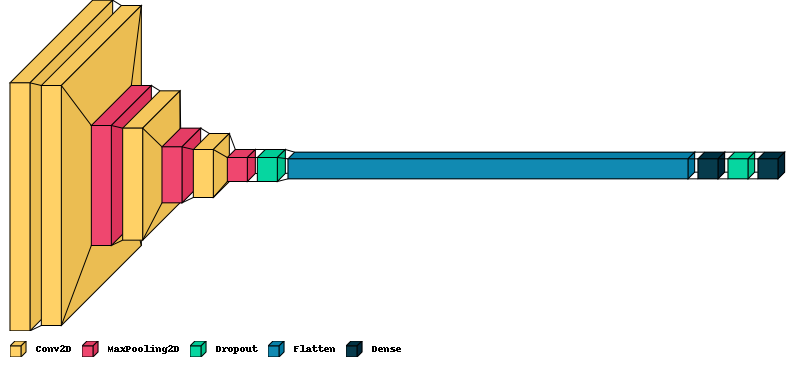

In [ ]:
visualkeras.layered_view(model1,to_file='output_model1.png',legend = True)

In [ ]:
# Adding Model check point Callback
mc = ModelCheckpoint(filepath="cervical_cancer_best_model1.hdf5", monitor= 'val_accuracy', verbose= 1, save_best_only= True, mode = 'auto');
call_back = [ mc ];

In [ ]:
# Fitting the Model
cnn = model1.fit(train_data,
                  steps_per_epoch= 28,
                  epochs= 32,
                  validation_data= val_data,
                  validation_steps= 6,
                  callbacks = call_back)

Epoch 1/32
28/28 [==============================] - ETA: 0s - loss: 1.4044 - accuracy: 0.3485
Epoch 1: val_accuracy improved from -inf to 0.55000, saving model to cervical_cancer_best_model1.hdf5
28/28 [==============================] - 45s 1s/step - loss: 1.4044 - accuracy: 0.3485 - val_loss: 1.1730 - val_accuracy: 0.5500
Epoch 2/32
28/28 [==============================] - ETA: 0s - loss: 1.0985 - accuracy: 0.5743
Epoch 2: val_accuracy improved from 0.55000 to 0.70833, saving model to cervical_cancer_best_model1.hdf5
28/28 [==============================] - 36s 1s/step - loss: 1.0985 - accuracy: 0.5743 - val_loss: 0.9502 - val_accuracy: 0.7083
Epoch 3/32
28/28 [==============================] - ETA: 0s - loss: 0.9595 - accuracy: 0.6625
Epoch 3: val_accuracy did not improve from 0.70833
28/28 [==============================] - 35s 1s/step - loss: 0.9595 - accuracy: 0.6625 - val_loss: 0.8115 - val_accuracy: 0.7067
Epoch 4/32
28/28 [==============================] - ETA: 0s - loss: 0.827

In [ ]:
# Checking the Accuracy of the Model
accuracy2 = model1.evaluate_generator(generator= test_data)[1]
print(f"The accuracy of your model is = {accuracy2} %")

The accuracy of your model is = 0.9211822748184204 %


Found 609 images belonging to 5 classes.
7/7 [==============================] - 4s 392ms/step


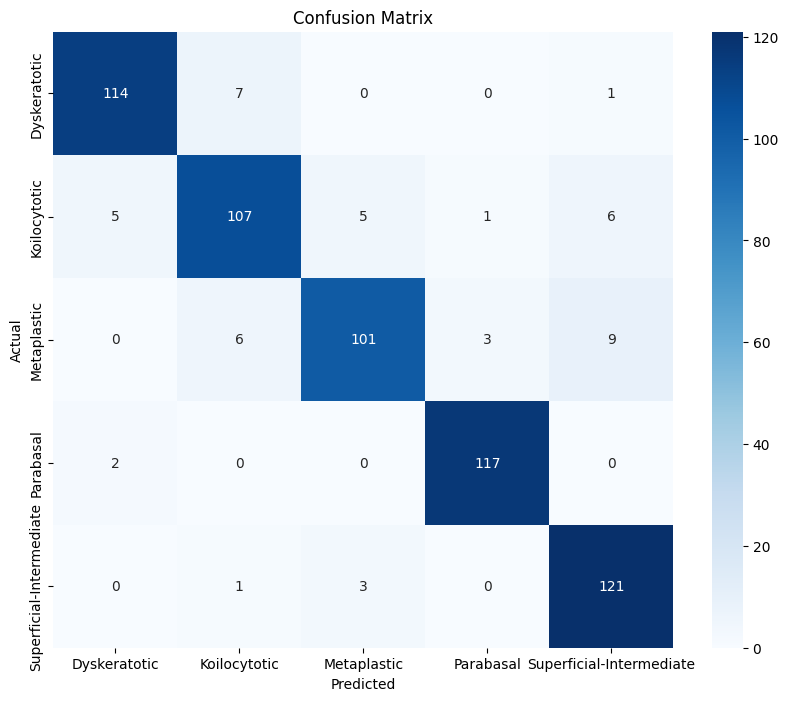

Classification Report:

                          precision    recall  f1-score   support

            Dyskeratotic       0.94      0.93      0.94       122
            Koilocytotic       0.88      0.86      0.87       124
             Metaplastic       0.93      0.85      0.89       119
               Parabasal       0.97      0.98      0.97       119
Superficial-Intermediate       0.88      0.97      0.92       125

                accuracy                           0.92       609
               macro avg       0.92      0.92      0.92       609
            weighted avg       0.92      0.92      0.92       609



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from keras.preprocessing import image
from keras.models import load_model

# Load the trained model
model1 = load_model("/content/cervical_cancer_best_model1.hdf5")

# Preparing the test data
test_datagen = image.ImageDataGenerator(rescale=1./255)
test_data = test_datagen.flow_from_directory(directory="./test",
                                             target_size=(64, 64),
                                             batch_size=100,
                                             class_mode='categorical',
                                             shuffle=False)

# Predicting the classes
Y_pred = model1.predict(test_data)
y_pred = np.argmax(Y_pred, axis=1)

# Getting the true labels
y_true = test_data.classes

# Generating the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Defining class names
class_names = ["Dyskeratotic", "Koilocytotic", "Metaplastic", "Parabasal", "Superficial-Intermediate"]

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Generating classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n")
print(report)


In [ ]:
h =  cnn.history;
h.keys();

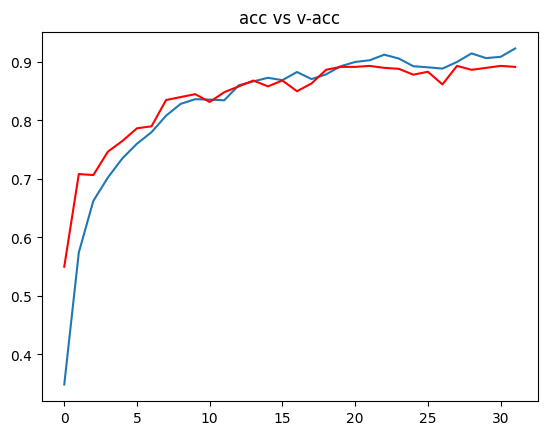

In [ ]:
# Ploting Accuracy In Training Set & Validation Set

plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'] , c = "red")
plt.title("acc vs v-acc")
plt.show()

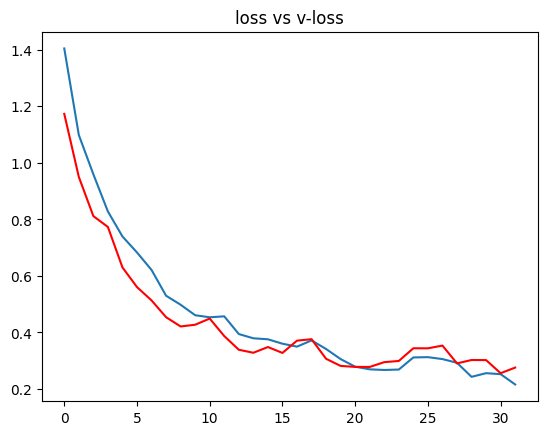

In [ ]:
# Ploting Loss In Training Set & Validation Set

plt.plot(h['loss'])
plt.plot(h['val_loss'] , c = "red")
plt.title("loss vs v-loss")
plt.show()

## CNN model dari Paper


In [ ]:
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, BatchNormalization, Activation
from keras.models import Sequential
from keras.optimizers import Adam
#CNN dari paper
model2 = Sequential()

# First Convolutional Block
model2.add(Conv2D(32, (3, 3), padding='same', input_shape=(64, 64, 3)))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

# Second Convolutional Block
model2.add(Conv2D(64, (3, 3), padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

# Third Convolutional Block
model2.add(Conv2D(128, (3, 3), padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

# Fourth Convolutional Block
model2.add(Conv2D(256, (3, 3), padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

# Adding Dropout to reduce overfitting
model2.add(Dropout(0.5))

# Flattening the layers
model2.add(Flatten())

# Fully connected layer
model2.add(Dense(128))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Dropout(0.5))

# Output layer
model2.add(Dense(5, activation='softmax'))

# Compiling the model
model2.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 64, 64, 32)        128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 64)       

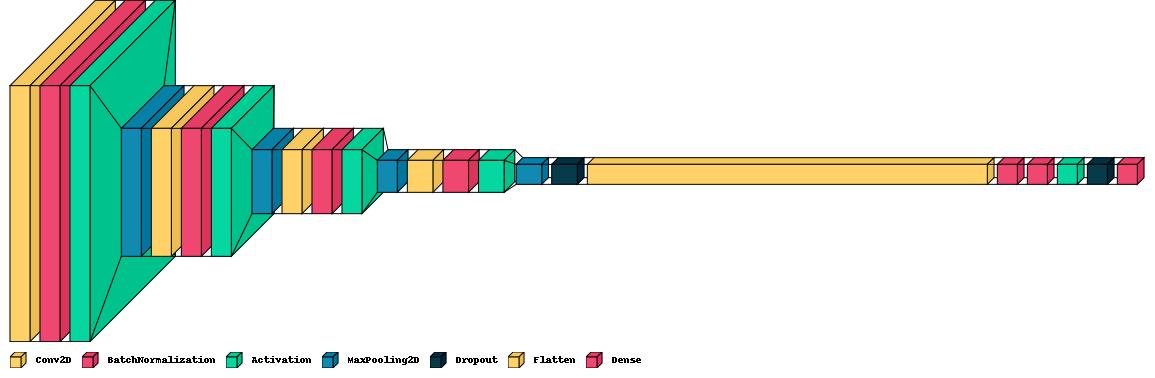

In [ ]:
visualkeras.layered_view(model2,to_file='output_model2.png',legend = True)

In [ ]:
# Adding Model check point Callback
mc2 = ModelCheckpoint(filepath="cervical_cancer_best_model2.hdf5", monitor= 'val_accuracy', verbose= 1, save_best_only= True, mode = 'auto');
call_back2 = [ mc2 ];

In [ ]:
# Fitting the Model
cnn2 = model2.fit(train_data,
                  steps_per_epoch= 28,
                  epochs= 32,
                  validation_data= val_data,
                  validation_steps= 6,
                  callbacks = call_back2 )

Epoch 1/32
28/28 [==============================] - ETA: 0s - loss: 1.4520 - accuracy: 0.4889
Epoch 1: val_accuracy improved from -inf to 0.28167, saving model to cervical_cancer_best_model2.hdf5
28/28 [==============================] - 69s 2s/step - loss: 1.4520 - accuracy: 0.4889 - val_loss: 1.6853 - val_accuracy: 0.2817
Epoch 2/32
28/28 [==============================] - ETA: 0s - loss: 0.9581 - accuracy: 0.6676
Epoch 2: val_accuracy did not improve from 0.28167
28/28 [==============================] - 71s 2s/step - loss: 0.9581 - accuracy: 0.6676 - val_loss: 1.9343 - val_accuracy: 0.1933
Epoch 3/32
28/28 [==============================] - ETA: 0s - loss: 0.8065 - accuracy: 0.7251
Epoch 3: val_accuracy did not improve from 0.28167
28/28 [==============================] - 55s 2s/step - loss: 0.8065 - accuracy: 0.7251 - val_loss: 2.3126 - val_accuracy: 0.1950
Epoch 4/32
28/28 [==============================] - ETA: 0s - loss: 0.7447 - accuracy: 0.7416
Epoch 4: val_accuracy did not imp

In [ ]:
# Checking the Accuracy of the Model
accuracy = model2.evaluate_generator(generator= test_data)[1]
print(f"The accuracy of your model is = {accuracy} %")

The accuracy of your model is = 0.9343185424804688 %


Found 609 images belonging to 5 classes.
7/7 [==============================] - 3s 339ms/step


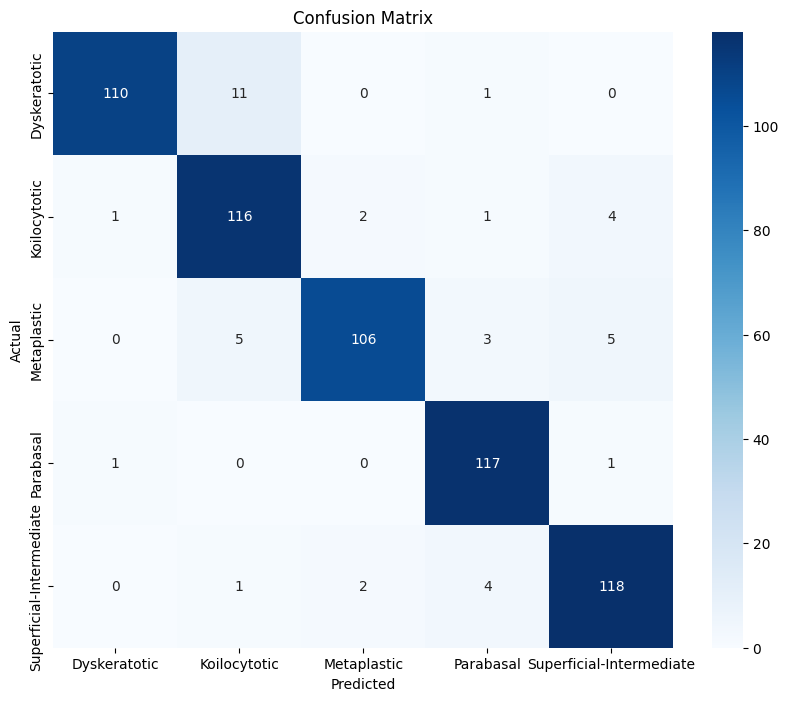

Classification Report:

                          precision    recall  f1-score   support

            Dyskeratotic       0.98      0.90      0.94       122
            Koilocytotic       0.87      0.94      0.90       124
             Metaplastic       0.96      0.89      0.93       119
               Parabasal       0.93      0.98      0.96       119
Superficial-Intermediate       0.92      0.94      0.93       125

                accuracy                           0.93       609
               macro avg       0.93      0.93      0.93       609
            weighted avg       0.93      0.93      0.93       609



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from keras.preprocessing import image
from keras.models import load_model

# Load the trained model
model2 = load_model("/content/cervical_cancer_best_model2.hdf5")

# Preparing the test data
test_datagen = image.ImageDataGenerator(rescale=1./255)
test_data = test_datagen.flow_from_directory(directory="./test",
                                             target_size=(64, 64),
                                             batch_size=100,
                                             class_mode='categorical',
                                             shuffle=False)

# Predicting the classes
Y_pred = model2.predict(test_data)
y_pred = np.argmax(Y_pred, axis=1)

# Getting the true labels
y_true = test_data.classes

# Generating the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Defining class names
class_names = ["Dyskeratotic", "Koilocytotic", "Metaplastic", "Parabasal", "Superficial-Intermediate"]

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Generating classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n")
print(report)


In [ ]:
h2 = cnn2.history;
h2.keys();

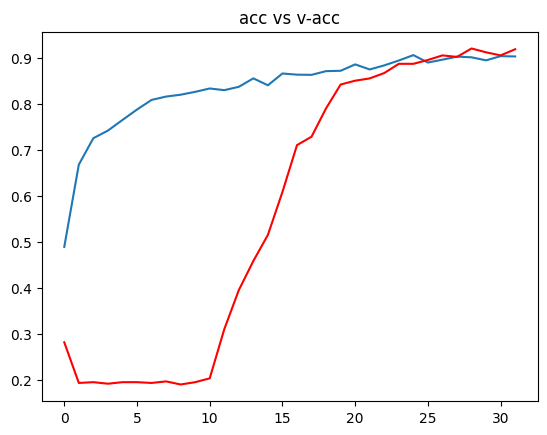

In [ ]:
# Ploting Accuracy In Training Set & Validation Set

plt.plot(h2['accuracy'])
plt.plot(h2['val_accuracy'] , c = "red")
plt.title("acc vs v-acc")
plt.show()

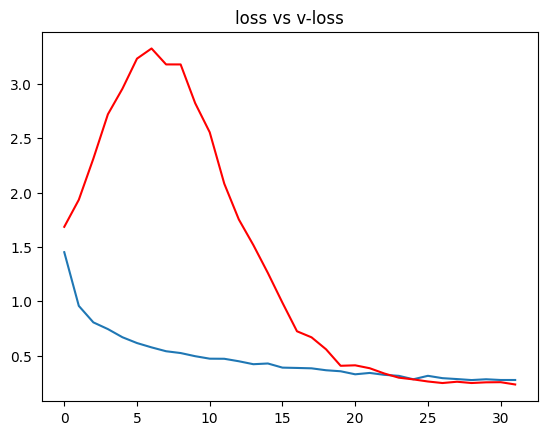

In [ ]:
# Ploting Loss In Training Set & Validation Set

plt.plot(h2['loss'])
plt.plot(h2['val_loss'] , c = "red")
plt.title("loss vs v-loss")
plt.show()